# Gravitational Wave Localizations and Galaxy Crossmatch Module

**Lecturer:** Leo Singer<br>
**Jupyter Notebook Author:** Leo Singer, Dave Cook, & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Winter School 2018.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-astro-school-2018-resources.html

## Objective
Learn how to use LIGO/Virgo localizations and match with galaxies

## Key steps
- Manipulate HEALPix localization files
- Cross-match a LIGO localization with a galaxy catalog

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* healpy
* ligo.skymap

### External packages
None

## Imports

First, some imports: Numpy, Matplotlib, Healpy, and parts of Astropy.

In [1]:
import astropy.utils.data
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

Here are some extra imports for the galaxy cross matching:

In [2]:
from astropy.table import Table, vstack, hstack, Column
import astropy.units as u
from astropy.coordinates import SkyCoord
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats

And configure Matplotlib to send plot output directly to the notebook:

In [3]:
%matplotlib inline

## HEALPix Basics

This section on using HEALPix localization files is adapted from the [LIGO/Virgo Public Alerts User Guide](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html).

### Download and read localization

Let's start by downloading a sample localization file from the User Guide. We could do this on the command line using `curl`:

    $ curl -O https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz

But after all, this is a Python lesson, so let's download the file using the handy `astropy.utils.data.download_file` function from Astropy.

In [4]:
url = 'https://emfollow.docs.ligo.org/userguide/_static/bayestar.fits.gz'
filename = astropy.utils.data.download_file(url)

Next, let's read in the HEALPix data using Healpy. Note that by default, Healpy only reads the first column, which provides the 2D probability distribution on the sky.

In [5]:
prob = hp.read_map(filename)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


### Manipulating HEALPix Coordinates

To get a quick look at a HEALPix data set, you can use the `hp.mollview` function:

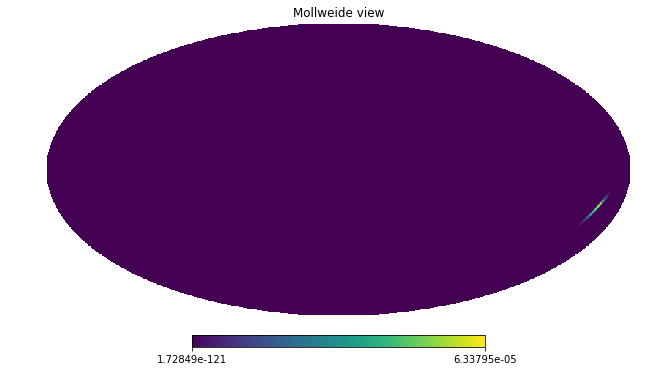

In [6]:
hp.mollview(prob)

What actually is stored in `prob`?

In [7]:
prob

array([2.70726059e-66, 1.27374324e-66, 2.62611513e-67, ...,
       2.04700874e-40, 1.05781210e-35, 4.44174764e-31])

It's a one-dimensional array! Yet it represents in 2D image. How does that work? HEALPix is a way to *index* equal-area regions on the unit sphere using integers.

To decode HEALPix indices, you need to know the resolution of the map, which is described by a parameter called `nside`. `nside` is the number of subdivisions of 12 base HEALPix tiles, so the relation between the length of a HEALPix array, `npix`, and its resolution, `nside`, is

$$
    \mathsf{npix} = 12 \cdot \mathsf{nside}^2.
$$

The functions `hp.npix2nside` and `hp.nside2npix` convert between length and resolution.

In [8]:
npix = len(prob)
npix

50331648

In [9]:
nside = hp.npix2nside(npix)
nside

2048

The function `hp.pix2ang` allow us to convert from (ra, dec) and HEALPix pixel index.

*Note*: by default, these functions return 'physics' spherical coordinates $(\theta, \phi)$ in radians, but you can switch to 'astronomy' spherical coordinates in degrees by passing the keyword argument `lonlat=True`.

Let's look up the right asce3nsion and declination of pixel 123.

In [10]:
ipix = 123
ra, dec = hp.pix2ang(nside, ipix, lonlat=True)
ra, dec

(129.375, 89.81725848475484)

The function `hp.ang2pix` does the opposite. Let's find the pixel that contains the point RA=194.95, Dec=27.98.

In [11]:
ra = 194.95
dec = 27.98
hp.ang2pix(nside, ra, dec, lonlat=True)

13361492

What is the most probable sky location? Just find the pixel with the maximum valuem, and then find its right ascension and declination.

In [12]:
ipix_max = np.argmax(prob)
ipix_max

32883013

In [13]:
hp.pix2ang(nside, ipix_max, lonlat=True)

(194.30419921875, -17.856895095545468)

### Probability distributions with scipy.stats

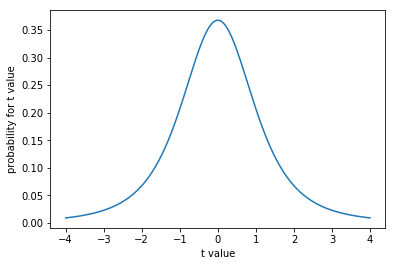

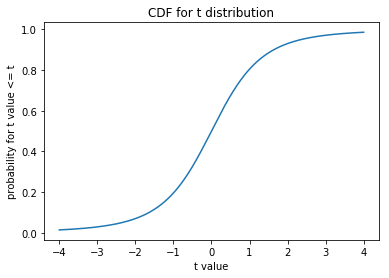

In [14]:
#Imagine I have a t statistic with 3 degrees of freedom.
#Scipy provides a t distribution class that we can use to get values from 
#the t statistic probability density function (PDF).
#As a start, we plot the PDF for a t statistic with 3 degrees of freedom:

# Make a t distribution object for t with 3 degrees of freedom
t_dist = scipy.stats.t(3)
# Plot the PDF
t_values = np.linspace(-4, 4, 1000)
plt.plot(t_values, t_dist.pdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value')
plt.show()

#The t distribution object t_dist can also give us the cumulative distribution function (CDF). 
#The CDF gives the area under the curve of the PDF at and to the left of the given t value:

plt.plot(t_values, t_dist.cdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value <= t')
plt.title('CDF for t distribution')
plt.show()

#Say I have a t value x drawn from a t distribution with 20 degrees of freedom. 
#The PDF gives the probability for given values of x. Because it is a probability density, 
#the sum of the probabilities of all possible values for x: ∞<x<∞ must be 1. 
#Therefore the total area under the PDF curve is 1, and the maximum value of the CDF is 1.

#The CDF gives us the area under the PDF curve at and to the left of a given t value x. 
#Therefore it is the probability that we will observe a value x<=t if we sample a value x 
#from a t distribution of (here).




0.11529193262241144

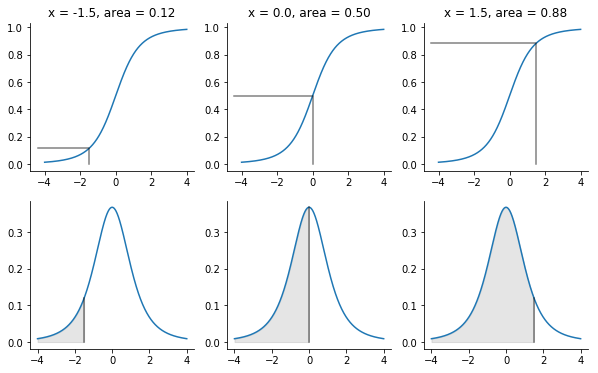

In [15]:
# Show relationship of PDF and CDF for three example t values.
#give the students most of the code for these plots
example_values = (-1.5, 0, 1.5)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
fig, axes = plt.subplots(2, len(example_values), figsize=(10, 6))
for i, x in enumerate(example_values):
    cdf_ax, pdf_ax = axes[:, i]
    cdf_ax.plot(t_values, cdf_values)
    pdf_ax.plot(t_values, pdf_values)
    # Fill area at and to the left of x.
    pdf_ax.fill_between(t_values, pdf_values,
                        where=t_values <= x,
                        color=fill_color)
    pd = t_dist.pdf(x)  # Probability density at this value.
    # Line showing position of x on x-axis of PDF plot.
    pdf_ax.plot([x, x],
                [0, pd], color=line_color)
    cd = t_dist.cdf(x)  # Cumulative distribution value for this x.
    # Lines showing x and CDF value on CDF plot.
    x_ax_min = cdf_ax.axis()[0]  # x position of y axis on plot.
    cdf_ax.plot([x, x, x_ax_min],
                [0, cd, cd], color=line_color)
    cdf_ax.set_title('x = {:.1f}, area = {:.2f}'.format(x, cd))
    # Hide top and right axis lines and ticks to reduce clutter.
    for ax in (cdf_ax, pdf_ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
#For example, say I have drawn a t value x at random from a t distribution 
#with 20 degrees of freedom. The probability that x<=1.5 is:

# Area of PDF at and to the left of 1.5
t_dist.cdf(1.5)
#>0.9253...

#The total area under the PDF is 1, and the maximum value for the CDF is 1. 
#Therefore the area of the PDF to the right of 1.5 must be:

# Area of PDF to the right of 1.5
1 - t_dist.cdf(1.5)
#>0.0746...

#This is the probability that our t value x will be >1.5. 
#In general, when we sample a value x at random from a t distribution, 
#the probability that x>q is given by:

#ℙ(x>q)=1−CDF(q)
#where CDF is the cumulative distribution function for a t value.


#have the students fill out the example for 90% or something



### Working with LIGO/Virgo 3D localizations

LIGO/Virgo localization files for compact binary mergers include directional estimates of distance. The distance information is stored in three additional columns. To get the distance estimates, we need to ask for all four columns: `PROB`, `DISTMU`, `DISTSIGMA`, and `DISTNORM`.

In [16]:
url = 'https://dcc.ligo.org/public/0146/G1701985/001/bayestar.fits.gz'
filename = astropy.utils.data.download_file(url)

In [17]:
prob, distmu, distsigma, distnorm = hp.read_map(
    filename, field=[0, 1, 2, 3])

npix = len(prob)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [18]:
#load in CLU catalog
clu=Table.read('data/CLU_NEDonly.fits')
clucoord=SkyCoord(ra=clu['RA']*u.deg,dec=clu['DEC']*u.deg)
nclu=np.size(clu)

#sky localization colmns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])
clu

CLUID,ID_OTHER,NAME,RA,DEC,DM,DM_KIN,BTC,A,RATIO_B2A,PA,TYPE,M21,RA_NED,DEC_NED,Z,ZERR,A_NED,B2A_NED,PA_NED,TYPE_NED,SOURCE,B_T,B_TERR,B_R25,B_R25ERR,FUV_1,FUVERR_1,NUV_1,NUVERR_1,RA_SDSS,DEC_SDSS,PETROMAG_U,PETROMAG_G,PETROMAG_R,PETROMAG_I,PETROMAG_Z,PETROMAGERR_U,PETROMAGERR_G,PETROMAGERR_R,PETROMAGERR_I,PETROMAGERR_Z,MODELMAG_U,MODELMAG_G,MODELMAG_R,MODELMAG_I,MODELMAG_Z,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,DESIGNATION_WISE,RA_WISE_1,DEC_WISE_1,W1MPRO,W1SIGMPRO,W1SNR,W2MPRO,W2SIGMPRO,W2SNR,W3MPRO,W3SIGMPRO,W3SNR,W4MPRO,W4SIGMPRO,W4SNR,DESIGNATION_2MASS,RA_2MASS,DEC_2MASS,R_K20FE,J_M_K20FE,J_MSIG_K20FE,J_FLG_K20FE,H_M_K20FE,H_MSIG_K20FE,H_FLG_K20FE,K_M_K20FE,K_MSIG_K20FE,K_FLG_K20FE,COORD_SOURCE,BTC_SOURCE,SIZE_SOURCE,DM_SOURCE,DM_KIN_OTHER,DM_RANGE,Z_SOURCE,DM_FLAG,RA_GALEX,DEC_GALEX,NUV_2,NUVERR_2,FUV_2,FUVERR_2,FLAGS_FUV,RA_WISE_2,DEC_WISE_2,WISE1,WISE1ERR,WISE4,WISE4ERR,FUV,NUV,FUVERR,NUVERR,MAGB,LUM_B,SFR_FUV,MSTAR,DISTMPC,HAGAL,HACAND,dP_dV,P,dP_dA,P_A
int64,bytes40,bytes30,float64,float64,int64,float64,float64,float64,float64,float64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes16,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,bytes3,bytes17,bytes17,bytes17,bytes47,float64,bytes3,int64,float64,float64,float32,float32,float32,float32,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,int16,int16,float32,float32,float32,float32
231192,N/A,2dFGRS S805Z417,0.00162,-56.14106,999999,33.18027481140323,nan,1e+20,1e+20,1e+20,N/A,1e+20,0.00162,-56.14106,0.010381646454334259,0.000297,1e+20,1e+20,1e+20,G,NED_20161120,nan,1e+20,nan,1e+20,20.3419,0.158386,20.0365,0.085881,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,nan,nan,nan,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,J000000.26-560827.5,0.0011127,-56.1409872,15.983,0.046,23.7,15.918,0.124,8.7,12.558,1e+20,0.3,9.002,1e+20,-0.4,N/A,1e+20,1e+20,1e+20,1e+20,1e+20,1,1e+20,1e+20,1,1e+20,1e+20,1,ned,N/A,N/A,nedz,33.0906,0.08967481140322775,NED,0,0.0026155762934943604,-56.14074783344139,20.0365,0.08588098,20.34193,0.15838555,0,0.0011127,-56.1409872,15.983,0.046,9.002,0.5,20.3419,20.0365,0.158386,nan,nan,nan,0.01642708362651844,79255697.86248614,43.25686,0,0,0.0,0.0,0.0,0.0
231193,472509,PGC597360,0.0068,-39.51309,999999,33.31510418687501,17.84,1e+20,0.812831,75.0,N/A,1e+20,0.0068,-39.51309,0.011046688072383404,0.000119,1e+20,1e+20,1e+20,G,NED_20161120,nan,1e+20,nan,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,nan,nan,nan,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,N/A,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,N/A,1e+20,1e+20,1e+20,1e+20,1e+20,1,1e+20,1e+20,1,1e+20,1e+20,1,ned,clu.v2,clu.v2,nedz,33.2254/33.1800,0.13510418687501158,NED,0,0.007313433062165586,-39.51229846299115,20.24918,0.11943007,20.61789,0.20752673,0,0.0,0.0,nan,0.0,nan,0.0,20.61789,20.24918,0.20752673,nan,17.84,5.307357561598291e+41,nan,nan,46.027866,0,0,0.0,0.0,0.0,0.0
231195,497360,PGC6,0.00905,15.88188,999999,34.66566288835784,15.08,1e+20,0.707946,87.6,-0.30000000,9.29,0.00905,15.88188,0.020575188100337982,3.3e-05,19.0,0.7,105.0,G,NED_20161120,nan,1e+20,nan,1e+20,17.8948,0.0523065,17.5015,0.0242858,0.0087450043021704,15.881712715063768,16.577778,15.449148,14.92187,14.651343,14.402801,0.02248089,0.006146703,0.004597746,0.0056472262,0.01087785,16.576433,15.463157,14.917557,14.641056,14.385708,0.013051505,0.0029402173,0.0027033475,0.0027071044,0.005214

In [19]:
#get coord of max prob density for plotting purposes
#ipix_max=np.where(prob == np.max(prob))
ipix_max = np.argmax(prob)
ra_max, dec_max = hp.pix2ang(nside, ipix_max, lonlat=True)
center = SkyCoord(ra=ra_max*u.deg,dec=dec_max*u.deg)
center

<SkyCoord (ICRS): (ra, dec) in deg
    (194.30419922, -17.8568951)>

/home/chummels/miniconda3/lib/python3.7/site-packages/astropy_healpix/core.py:519: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy_healpix/core.py:484: RuntimeWarning: invalid value encountered in ring_to_nested
  return _core.ring_to_nested(ring_index, nside)


/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]


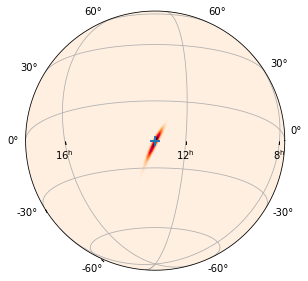

In [20]:
#plot up the sky localization and overplot the galaxies
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx(filename, cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=2)

In [21]:
#calc probability density per area on the sky for each galaxy
dp_dA=prob[ipix]/pixarea
clu['dP_dA']=dp_dA

#probability along radial distance
dp_dr=clu['DISTMPC']**2 * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['DISTMPC'])

#calc probability density per volume for each galaxy
dp_dV=prob[ipix] * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['DISTMPC'])/pixarea 
clu['dP_dV']=dp_dV

In [22]:
#use normalized cumulative dist function to calculate Volume P-value for each galaxy
clu.sort('dP_dV')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dV'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icut90=np.where(clu['P'] <= 0.9)
clucut90=clu[icut90]
clucut90coord=SkyCoord(ra=clucut90['RA']*u.deg,dec=clucut90['DEC']*u.deg)

print('# of galaxies in 90%% volume = %i' %(np.size(icut90)))

#sort by WISE 1 Luminosity (proportional to galaxy stellar mass)
clucut90.sort('P')
clucut90.reverse()

#then print list of prioritized galaxies
clucut90['NAME','dP_dV','P'].pprint(max_lines=20)

# of galaxies in 90% volume = 3047
          NAME                   dP_dV                    P           
------------------------ ---------------------- ----------------------
                PGC47394  6.317992998346537e-64      0.899883254360382
                PGC82565  6.317992998346537e-64     0.8997641503042281
                PGC49468  6.317992998346537e-64     0.8996450462480743
                PGC37565  6.317992998346537e-64     0.8995259421919205
                PGC70582  6.317992998346537e-64     0.8994068381357666
SDSS_J124305.87+242703.8  6.334407010119384e-64     0.8992877340796128
          MCG -02-05-043  6.334407010119384e-64      0.899168320593648
                PGC40483   6.36402347040082e-64     0.8990489071076831
                     ...                    ...                    ...
                UGCA 339 2.2638103395560794e-63  0.0034142113450347576
         HIPASS J1008-33 2.2638525648239792e-63   0.002987447665691437
          [TSK2008] 0687  2.26386644442391

## Exercise for students

Following the examples above, find galaxies in 90% prob contour for GW170817, then sort by Wise1 luminosity.

Information on WISE zeropoints and flux transformations
http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

In [23]:
#load in CLU catalog
clu=Table.read('data/CLU_NEDonly.fits')
#clu=Table.read('data/CLU_20170106_galexwise_DaveUpdate.fits')
clucoord=SkyCoord(ra=clu['RA']*u.deg,dec=clu['DEC']*u.deg)
nclu=np.size(clu)

#sky localization colmns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])

#load in healpix map
prob,distmu,distsigma,distnorm=hp.read_map('data/GW170817_prelim.fits.gz',field=[0,1,2,3],dtype=('f8','f8','f8','f8'))
npix=len(prob)
nside=hp.npix2nside(npix)
pixarea=hp.nside2pixarea(nside)

#get coord of max prob density for plotting purposes
#ipix_max=np.where(prob == np.max(prob))
ipix_max = np.argmax(prob)
theta_max, phi_max = hp.pix2ang(nside, ipix_max)
ra_max = np.rad2deg(phi_max)
dec_max = np.rad2deg(0.5 * np.pi - theta_max)
center = SkyCoord(ra=ra_max*u.deg,dec=dec_max*u.deg)

print(center)
#calc hp index for each galaxy
theta=0.5 * np.pi - clucoord.dec.to('rad').value
phi=clucoord.ra.to('rad').value
ipix=hp.ang2pix(nside,theta,phi)
#calc probability density per volume for each galaxy
dp_dV=prob[ipix] * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['DISTMPC'])/pixarea 
clu['dP_dV']=dp_dV

#use normalized cumulative dist function to calculate Volume P-value for each galaxy
clu.sort('dP_dV')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dV'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icut90=np.where(clu['P'] <= 0.9)
clucut90=clu[icut90]
clucut90coord=SkyCoord(ra=clucut90['RA']*u.deg,dec=clucut90['DEC']*u.deg)

print('# of galaxies in 90%% volume = %i' %(np.size(icut90)))
#sort the galaxies by WISE band 1 luminosity,then print list of prioritized galaxies
W1lumcol=Column(np.zeros(nclu,dtype='f8'),name='LumW1')
clu.add_column(W1lumcol)

#constants needed
F0=309.540
clight=2.99792458e18   #Angstoms/sec
lamW1=33526.   #Angtroms

fluxJyW1=F0*10**(-0.4*clucut90['W1MPRO'])  #in Jy
fluxdenW1=fluxJyW1*1e-23  #erg/s/cm^2/Hz
freqW1=clight/lamW1

#distcm=n4*np.pi*(cp.float128(lucut90['DISTMPC'])*1.086e24)**2)
clucut90['LumW1']=fluxdenW1 * freqW1 * 4*np.pi*(np.float128(clucut90['DISTMPC'])*1.086e24)**2

#sort by WISE 1 Luminosity (proportional to galaxy stellar mass)
clucut90.sort('LumW1')
clucut90.reverse()

#then print list of prioritized galaxies
clucut90['NAME','LumW1','dP_dV','P'].pprint(max_lines=20)



NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
<SkyCoord (ICRS): (ra, dec) in deg
    (197.35839844, -25.61308322)>
# of galaxies in 90% volume = 42
            NAME                       LumW1           ...          P         
---------------------------- ------------------------- ... -------------------
                    PGC45466 1.0884088954320000597e+42 ...  0.6995353723555456
                    PGC45657    7.5032646027206775e+41 ...  0.7965022626584416
                    PGC45426  7.367336809737711801e+41 ...  0.3905416510700604
                    PGC45514  7.159408041749106282e+41 ...   0.636392013632011
                    PGC45408  6.191420321536100089e+41 ... 0.20082875617890292
                    PGC46199  3.728938562939855379e+41 ...  0.7710150928931331
                    PGC46410  2.957639646390979745e+41 ...  0.8792942624546624
               

## Exercise for students

Now, plot up the sky localization and overplot the galaxies on it.

/home/chummels/miniconda3/lib/python3.7/site-packages/astropy_healpix/core.py:519: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy_healpix/core.py:484: RuntimeWarning: invalid value encountered in ring_to_nested
  return _core.ring_to_nested(ring_index, nside)
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/chummels/miniconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  disco

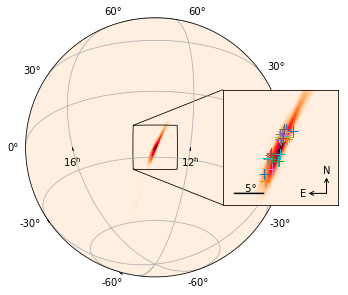

In [24]:
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('data/GW170817_prelim.fits.gz', cmap='cylon')
for coord in clucut90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)